# Satellite Data Acquisition - Multi-Image SAR Download Examples (S1MPC)

Advanced examples for downloading Sentinel-1 SAR time series from Microsoft Planetary Computer.

SAR data works in all weather conditions - no cloud coverage issues!

Author: Peter Kongstad

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box, Point

from sat_data_acquisition import SatDataClient, ProcessingParams, SaveParams, configure_logging
from sat_data_acquisition.processing import save_data
from sat_data_acquisition.config.settings import SatDataSettings

In [9]:
# Configure logging
configure_logging(verbose=False)

## Example 1: Single Area SAR Time Series

Download multiple SAR images over time to monitor changes.

In [10]:
# Define area as bounding box
copenhagen_center = Point(12.5683, 55.6761)
buffer = 0.024

geometry = box(
    copenhagen_center.x - buffer,
    copenhagen_center.y - buffer,
    copenhagen_center.x + buffer,
    copenhagen_center.y + buffer
)

print(f"Area: {geometry.bounds}")

Area: (12.544300000000002, 55.6521, 12.5923, 55.7001)


In [11]:
# Initialize client and configure processing parameters
client = SatDataClient()

processing_params = ProcessingParams(
    satellite='S1MPC',
    search_method='geometry',
    start_date='2024-06-01',
    end_date='2024-08-31',
    bands=['vv', 'vh'],
    sort=True,
    clip_method='geometry'
)
# Note: No cloud_coverage parameter for SAR!

print("[OK] Configured")

[OK] Configured


In [12]:
# Search and download SAR images
dataset = client.search_and_create_image(
    geometry=geometry,
    processing_params=processing_params,
    area_name='copenhagen'
)

n_images = len(dataset.time)
print(f"[OK] Downloaded {n_images} SAR images")

[OK] Downloaded 31 SAR images


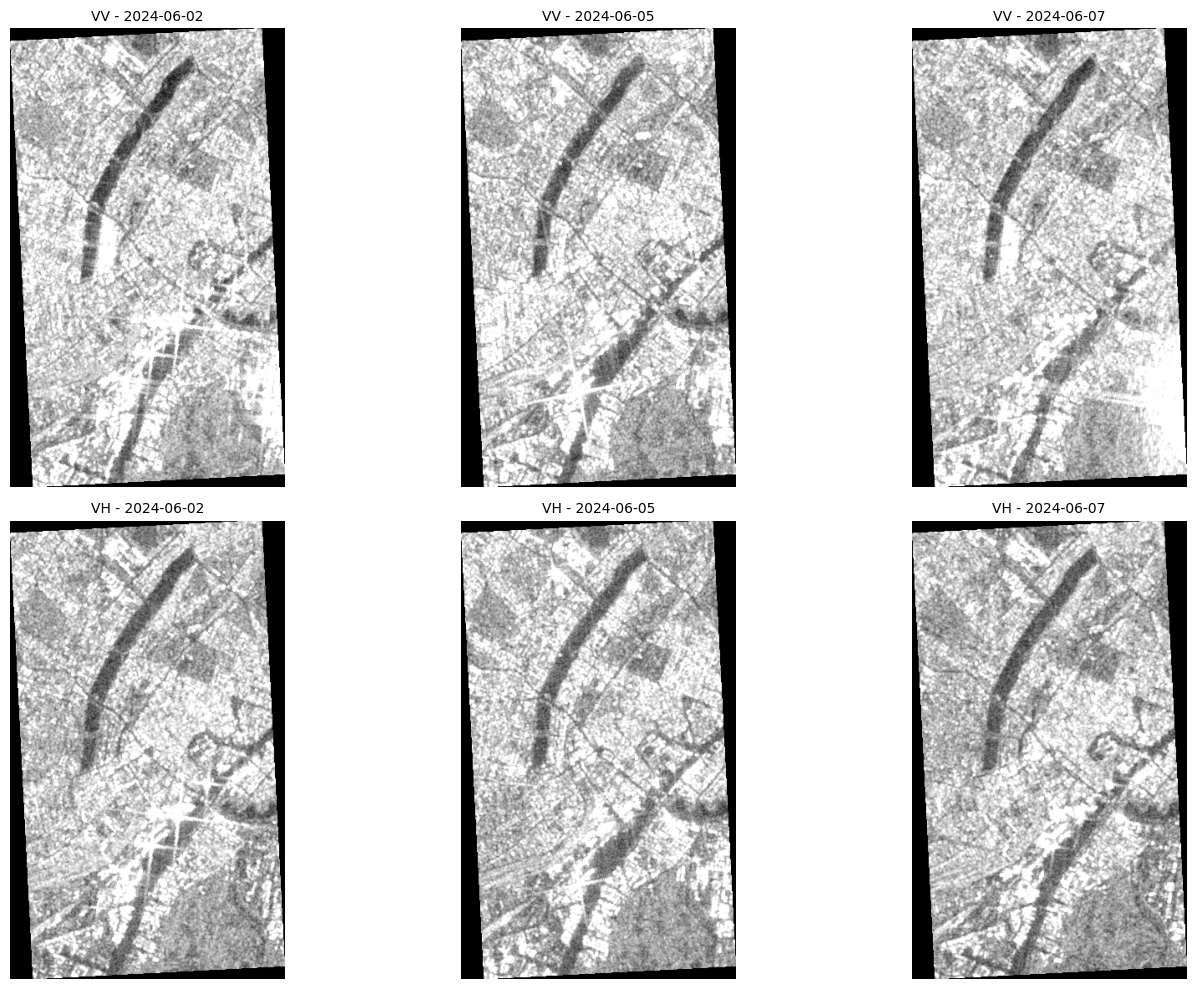


Visualization saved as: s1mpc_time_series.png


In [13]:
# Visualize SAR time series (VV on top row, VH on bottom row)
if len(dataset.time) > 0:
    n_display = min(len(dataset.time), 3)  # Show up to 3 dates
    cols = n_display
    rows = 2  # Top row = VV, Bottom row = VH
    
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 10))
    if cols == 1:
        axes = axes.reshape(-1, 1)
    
    for idx, time_val in enumerate(dataset.time.values[:n_display]):
        image_slice = dataset.sel(time=time_val)
        date_str = str(time_val)[:10]
        
        # Top row: VV polarization
        vv = image_slice['vv'].values
        vv_db = 10 * np.log10(np.clip(vv, 1e-10, None))
        im_vv = axes[0, idx].imshow(vv_db, cmap='gray', vmin=-25, vmax=0)
        axes[0, idx].set_title(f'VV - {date_str}', fontsize=10)
        axes[0, idx].axis('off')
        
        # Bottom row: VH polarization
        vh = image_slice['vh'].values
        vh_db = 10 * np.log10(np.clip(vh, 1e-10, None))
        im_vh = axes[1, idx].imshow(vh_db, cmap='gray', vmin=-30, vmax=-5)
        axes[1, idx].set_title(f'VH - {date_str}', fontsize=10)
        axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('s1mpc_time_series.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved as: s1mpc_time_series.png")
else:
    print("No images found for the specified criteria")

## Example 2: Multiple Areas from GeoJSON

Download SAR images for multiple areas. Great for monitoring multiple sites in cloudy regions!

In [14]:
# Load GeoJSON with multiple areas
gdf = gpd.read_file('../../data/geojson/example_areas.geojson')

print(f"[OK] Loaded {len(gdf)} areas")
print(gdf[['name', 'description']])

[OK] Loaded 3 areas
         name                           description
0  copenhagen     Copenhagen, Denmark - City Center
1      london  London, United Kingdom - Westminster
2     seattle               Seattle, USA - Downtown


In [15]:
# Process images for each area
results = []

for _, row in gdf.iterrows():
    area_name = row['name']
    geometry = row.geometry
    
    try:
        dataset = client.search_and_create_image(
            geometry=geometry,
            processing_params=processing_params,
            area_name=area_name,
        )
        
        n_images = len(dataset.time)
        print(f"[OK] {area_name}: {n_images} images")
        
        results.append({
            'area': area_name,
            'n_images': n_images,
            'status': 'success'
        })
        
    except Exception as e:
        print(f"[WARN] {area_name} failed: {str(e)[:100]}")
        results.append({
            'area': area_name,
            'n_images': 0,
            'status': f'failed: {str(e)[:50]}'
        })

print(f"\n[OK] Processed {len(results)} areas")

[OK] copenhagen: 31 images
[OK] london: 29 images
[OK] seattle: 26 images

[OK] Processed 3 areas


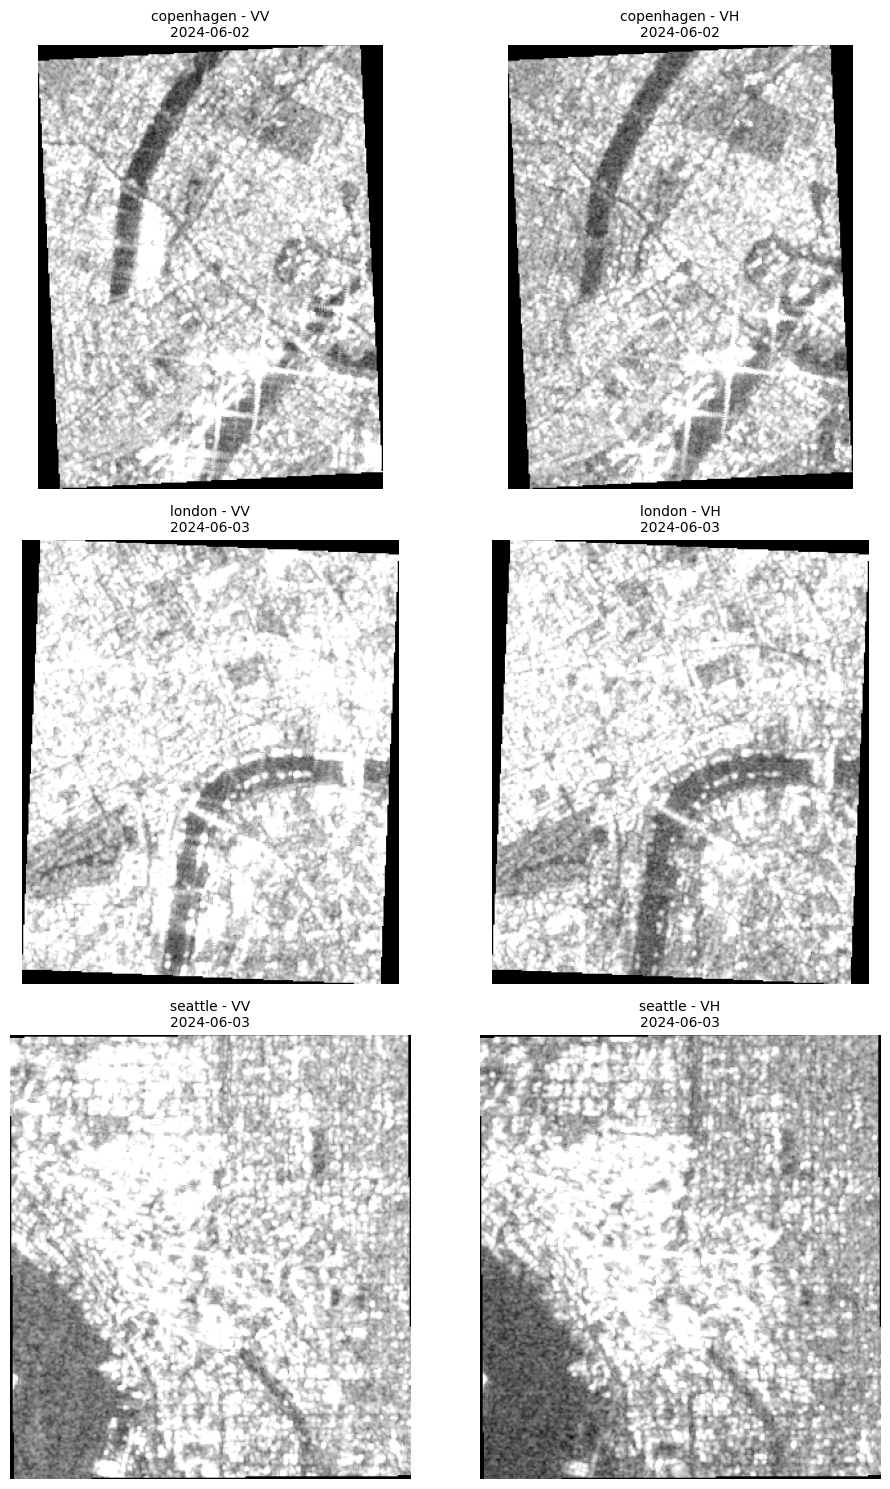


Visualization saved as: s1mpc_multi_area.png


In [16]:
# Visualize one image per area with VV and VH side-by-side
if len(results) > 0:
    max_areas = min(len(gdf), 3)  # Show up to 3 areas
    
    fig, axes = plt.subplots(max_areas, 2, figsize=(10, 5*max_areas))
    if max_areas == 1:
        axes = axes.reshape(1, -1)
    
    for area_idx, (_, row) in enumerate(gdf.iterrows()):
        if area_idx >= max_areas:
            break
        
        area_name = row['name']
        geometry = row.geometry
        
        try:
            # Re-fetch the data for this area
            dataset = client.search_and_create_image(
                geometry=geometry,
                processing_params=processing_params,
                area_name=area_name,
            )
            
            if len(dataset.time) > 0:
                # Use the first image
                image_slice = dataset.sel(time=dataset.time.values[0])
                date_str = str(dataset.time.values[0])[:10]
                
                # Left column: VV polarization
                vv = image_slice['vv'].values
                vv_db = 10 * np.log10(np.clip(vv, 1e-10, None))
                axes[area_idx, 0].imshow(vv_db, cmap='gray', vmin=-25, vmax=0)
                axes[area_idx, 0].set_title(f'{area_name} - VV\n{date_str}', fontsize=10)
                axes[area_idx, 0].axis('off')
                
                # Right column: VH polarization
                vh = image_slice['vh'].values
                vh_db = 10 * np.log10(np.clip(vh, 1e-10, None))
                axes[area_idx, 1].imshow(vh_db, cmap='gray', vmin=-30, vmax=-5)
                axes[area_idx, 1].set_title(f'{area_name} - VH\n{date_str}', fontsize=10)
                axes[area_idx, 1].axis('off')
            else:
                # No images found - hide both slots
                axes[area_idx, 0].axis('off')
                axes[area_idx, 1].axis('off')
                axes[area_idx, 0].text(0.5, 0.5, f'{area_name}\nNo images', 
                                       ha='center', va='center', transform=axes[area_idx, 0].transAxes)
                    
        except Exception as e:
            print(f"[WARN] Could not visualize {area_name}: {e}")
            axes[area_idx, 0].axis('off')
            axes[area_idx, 1].axis('off')
            axes[area_idx, 0].text(0.5, 0.5, f'{area_name}\nError', 
                                   ha='center', va='center', transform=axes[area_idx, 0].transAxes)
    
    plt.tight_layout()
    plt.savefig('s1mpc_multi_area.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved as: s1mpc_multi_area.png")
else:
    print("No areas to visualize")

In [17]:
# Summary
import pandas as pd
df = pd.DataFrame(results)
print("\nProcessing Summary:")
print(df)


Processing Summary:
         area  n_images   status
0  copenhagen        31  success
1      london        29  success
2     seattle        26  success


## SAR Analysis Tips

### VV/VH Ratio for Classification
```python
vv = dataset['vv'].values
vh = dataset['vh'].values
ratio = vv / (vh + 1e-10)  # Add small value to avoid division by zero
ratio_db = 10 * np.log10(ratio)
```

### Change Detection
```python
# Compare two dates
img1 = dataset.sel(time=dataset.time.values[0])['vv'].values
img2 = dataset.sel(time=dataset.time.values[-1])['vv'].values
change = img2 - img1  # Difference image
```

### Applications
- **Flood mapping**: Water appears dark in SAR
- **Ship detection**: Bright targets on dark water
- **Agriculture monitoring**: Works through clouds
- **Urban change detection**: High backscatter from buildings